# Setup

In [1]:
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)

        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
            fd.DirichletBC(self.V['u'], ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 3)]  # outflow

        self.bc['up']['u'] = [[bcu, 'fixed']]
        self.bc['up']['p'] = [[bcp, 'fixed']]
        
    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'eps' : fd.Constant(0.01),
            'K' : fd.Constant(10.0),
            'f_1' : fd.conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 0.1, 0),
            'f_2' : fd.conditional(pow(x-0.1, 2)+pow(y-0.3,2)<0.05*0.05, 0.1, 0),
            'f_3' : fd.Constant(0.0)
        }

# Solve

In [19]:
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace},
'degree': {'u': 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres'},
'subsystem_class' : {'up' : navier_stokes},
'precond': {'u': 'sor', 'p' : 'sor'},
'dt' : 0.0005,
 'T' : 1.0 }                         
)

mesh = fd.Mesh("../../../meshes/cylinder.msh")
solver = pde_solver([['u', 'p']], mesh, solver_parameters)

solver_parameters = recursive_update(solver_parameters,
{
    'space': {'c': fd.MixedFunctionSpace},
    'degree': {'c': 1},
    'order' : {'c' : 3},
    'linear_solver': {'c': 'gmres'},
    'subsystem_class' : {'c' : reactions},
    'precond': {'c': 'sor'}
})

solver.add_subsystem('c', solver_parameters)
solver.setup_bcs()
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
solver.define(['c'], 'c')
solver.solve()

{'up': {'u': [[[<firedrake.bcs.DirichletBC object at 0x7f0c99e65be0>, <firedrake.bcs.DirichletBC object at 0x7f0c99e65518>], 'fixed']], 'p': [[[<firedrake.bcs.DirichletBC object at 0x7f0c99d3d780>], 'fixed']]}, 'c': {'c': [[None, None], [None, None], [None, None]]}}
[None, None, None, None, None, None]
['u', 'p', 'u', 'c']
u up 0
p up 1
c c 3
time = 1.000


# Plotting

(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

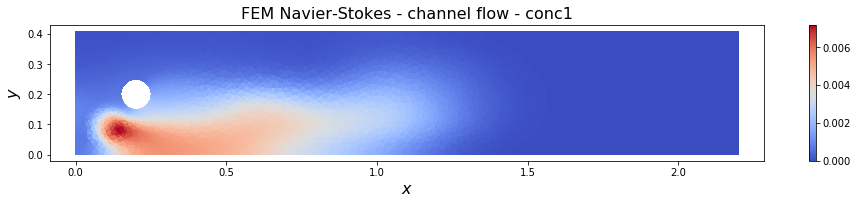

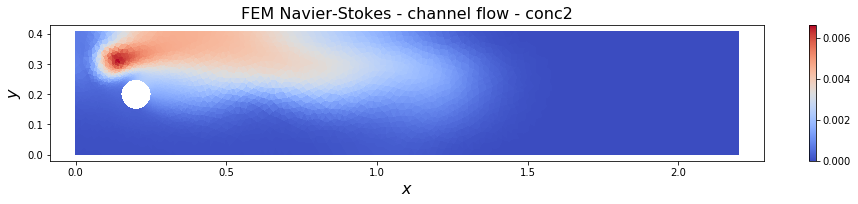

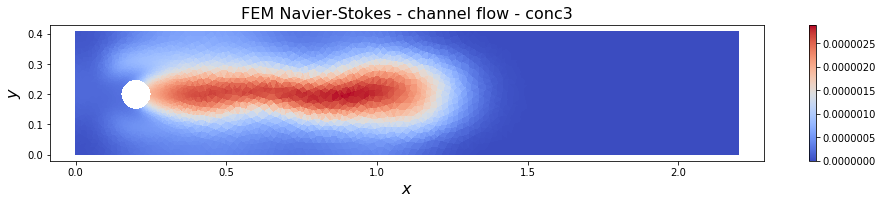

In [20]:
c1, c2, c3 = solver.form_args['c_'].split()

fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(c1,axes=ax4)
ax4.axis('equal')

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(c2,axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(c3,axes=ax6)
ax6.axis('equal')